Flavor physics analysis looking for decays of D or B mesons. In this example we run the reconstruction of Ds->phi(mumu)pi decays, looking for two collimated muons and a charged track originating from a common vertex. The analysis is performed on ntuples produced running on CMS data in the MINIAOD format.

## Basic imports

In [1]:
import sys, os, time
start = time.time()
import json
import ROOT

## Dask scheduler

In [2]:
from dask.distributed import Client, performance_report

In [3]:
Local = False

if Local:
    from dask.distributed import LocalCluster
    cluster = LocalCluster()
    client = Client(cluster.scheduler.address)

Now start new Dask cluster, scale the number of workers

In [4]:
from dask.distributed import Client

client = Client("tcp://dask-simonef-z38pz-scheduler.jhub:8786")
client

<Client: 'tcp://10.42.3.151:8786' processes=8 threads=8, memory=16.00 GiB>

In [5]:
# fill this cell with "<>" button of Dask labextension

In [6]:
client.restart() #Execute this only to restart the workers (to relaunch the notebook, for example)

<Client: 'tcp://10.42.3.151:8786' processes=8 threads=8, memory=16.00 GiB>

## Declare custom C++ functions 

In [7]:
text_file = open("Utilities.h", "r")
data = text_file.read()

import correctionlib
correctionlib.register_pyroot_binding()

def my_initialization_function():
    ROOT.gInterpreter.Declare('{}'.format(data))
    ROOT.gInterpreter.Declare('auto corrSet = correction::CorrectionSet::from_file("Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json");') 
    # obtained from https://gitlab.cern.ch/cms-muonPOG/muonefficiencies/-/raw/master/Run2/UL/2017/2017_Jpsi/Efficiency_muon_trackerMuon_Run2017_UL_ID.json
    ROOT.gInterpreter.Declare('auto corr = corrSet->at("NUM_MediumID_DEN_TrackerMuons");')

ROOT.RDF.Experimental.Distributed.initialize(my_initialization_function)

## X509 proxy configuration
The `/tmp/x509up_u` file should be generated prior running the notebook using `voms-proxy-init -cert ../cert/usercert.pem -key ../cert/userkey.pem`

In [8]:
from distributed.diagnostics.plugin import UploadFile
client.register_plugin(UploadFile("/tmp/x509up_u0"))

{'tcp://10.42.0.103:39267': {'status': 'OK'},
 'tcp://10.42.2.120:34585': {'status': 'OK'},
 'tcp://10.42.2.121:37701': {'status': 'OK'},
 'tcp://10.42.3.152:41073': {'status': 'OK'},
 'tcp://10.42.3.153:34233': {'status': 'OK'},
 'tcp://10.42.5.126:42413': {'status': 'OK'},
 'tcp://10.42.6.156:38785': {'status': 'OK'},
 'tcp://10.42.6.157:39019': {'status': 'OK'}}

In [9]:
def set_proxy(dask_worker):
    import os
    import shutil
    working_dir = dask_worker.local_directory
    proxy_name = 'x509up_u0'
    os.environ['X509_USER_PROXY'] = working_dir + '/' + proxy_name
    os.environ['X509_CERT_DIR']="/cvmfs/grid.cern.ch/etc/grid-security/certificates/"
    return os.environ.get("X509_USER_PROXY"), os.environ.get("X509_CERT_DIR") 

In [10]:
client.run(set_proxy)

{'tcp://10.42.0.103:39267': ('/tmp/dask-scratch-space/worker-ff9b4xba/x509up_u0',
  '/cvmfs/grid.cern.ch/etc/grid-security/certificates/'),
 'tcp://10.42.2.120:34585': ('/tmp/dask-scratch-space/worker-psmkrrqt/x509up_u0',
  '/cvmfs/grid.cern.ch/etc/grid-security/certificates/'),
 'tcp://10.42.2.121:37701': ('/tmp/dask-scratch-space/worker-u0bdvy74/x509up_u0',
  '/cvmfs/grid.cern.ch/etc/grid-security/certificates/'),
 'tcp://10.42.3.152:41073': ('/tmp/dask-scratch-space/worker-lceghqr8/x509up_u0',
  '/cvmfs/grid.cern.ch/etc/grid-security/certificates/'),
 'tcp://10.42.3.153:34233': ('/tmp/dask-scratch-space/worker-qw0tvpuw/x509up_u0',
  '/cvmfs/grid.cern.ch/etc/grid-security/certificates/'),
 'tcp://10.42.5.126:42413': ('/tmp/dask-scratch-space/worker-fldvl5tj/x509up_u0',
  '/cvmfs/grid.cern.ch/etc/grid-security/certificates/'),
 'tcp://10.42.6.156:38785': ('/tmp/dask-scratch-space/worker-txheh_xv/x509up_u0',
  '/cvmfs/grid.cern.ch/etc/grid-security/certificates/'),
 'tcp://10.42.6.157:

In [11]:
# Loading PROXY locally
os.environ['X509_USER_PROXY'] = "/tmp/x509up_u0"
os.environ['X509_CERT_DIR'] = "/cvmfs/grid.cern.ch/etc/grid-security/certificates/"

In [12]:
def ls(dask_worker):
    import os
    working_dir = dask_worker.local_directory
    return os.listdir(working_dir)
    
def clear_nodes(dask_worker):
    import os
    os.popen('rm ./*.root')
    return True    

In [13]:
#client.run(clear_nodes)
client.run(ls)

{'tcp://10.42.0.103:39267': ['storage', 'x509up_u0'],
 'tcp://10.42.2.120:34585': ['storage', 'x509up_u0'],
 'tcp://10.42.2.121:37701': ['storage', 'x509up_u0'],
 'tcp://10.42.3.152:41073': ['storage', 'x509up_u0'],
 'tcp://10.42.3.153:34233': ['storage', 'x509up_u0'],
 'tcp://10.42.5.126:42413': ['storage', 'x509up_u0'],
 'tcp://10.42.6.156:38785': ['storage', 'x509up_u0'],
 'tcp://10.42.6.157:39019': ['storage', 'x509up_u0']}

Configuration files or additional input files (i.e. scale factors, PU reweighting) should be pushed to the worker

In [14]:
myfile_path = 'Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json'
client.register_plugin(UploadFile(myfile_path))
client.run(ls)

{'tcp://10.42.0.103:39267': ['Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json',
  'storage',
  'x509up_u0'],
 'tcp://10.42.2.120:34585': ['Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json',
  'storage',
  'x509up_u0'],
 'tcp://10.42.2.121:37701': ['Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json',
  'storage',
  'x509up_u0'],
 'tcp://10.42.3.152:41073': ['Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json',
  'storage',
  'x509up_u0'],
 'tcp://10.42.3.153:34233': ['Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json',
  'storage',
  'x509up_u0'],
 'tcp://10.42.5.126:42413': ['Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json',
  'storage',
  'x509up_u0'],
 'tcp://10.42.6.156:38785': ['Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json',
  'storage',
  'x509up_u0'],
 'tcp://10.42.6.157:39019': ['Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json',
  'storage',
  'x509up_u0']}

## Define chain of rootfiles to analyze
ntuples corresponding to different datasets and eras are defined in a configuration json file

In [15]:
configjson = "input.json"

with open(configjson, "r") as f:
    config = json.loads(f.read())

Set here which dataset to use

In [16]:
dataset_list = ["2017B"]

for dataset in dataset_list:
  path = "root://eosuser.cern.ch//eos/user/f/fsimone/lustre/"+config[dataset]["rootpath"]
  print(path)
  treename = config[dataset]["treename"]
  print(treename)

root://eosuser.cern.ch//eos/user/f/fsimone/lustre/SkimPhiPi_UL2017_Run2017B_ModFilter_Mini_v2/210131_221715/0000/
Tree3Mu/ntuple


In [17]:
#generating the list of all .root files
chain = []
nfiles = 0
for dataset in dataset_list:
   files = config[dataset]["files"].split()
   for file in files:
       path = "root://eosuser.cern.ch//eos/user/f/fsimone/lustre/"+config[dataset]["rootpath"]
       chain.append(path+"/"+file)
       
nfiles = len(chain)
print(chain)
print(nfiles)

['root://eosuser.cern.ch//eos/user/f/fsimone/lustre/SkimPhiPi_UL2017_Run2017B_ModFilter_Mini_v2/210131_221715/0000//Tree_PhiPi_1.root', 'root://eosuser.cern.ch//eos/user/f/fsimone/lustre/SkimPhiPi_UL2017_Run2017B_ModFilter_Mini_v2/210131_221715/0000//Tree_PhiPi_2.root', 'root://eosuser.cern.ch//eos/user/f/fsimone/lustre/SkimPhiPi_UL2017_Run2017B_ModFilter_Mini_v2/210131_221715/0000//Tree_PhiPi_3.root', 'root://eosuser.cern.ch//eos/user/f/fsimone/lustre/SkimPhiPi_UL2017_Run2017B_ModFilter_Mini_v2/210131_221715/0000//Tree_PhiPi_4.root', 'root://eosuser.cern.ch//eos/user/f/fsimone/lustre/SkimPhiPi_UL2017_Run2017B_ModFilter_Mini_v2/210131_221715/0000//Tree_PhiPi_5.root', 'root://eosuser.cern.ch//eos/user/f/fsimone/lustre/SkimPhiPi_UL2017_Run2017B_ModFilter_Mini_v2/210131_221715/0000//Tree_PhiPi_6.root', 'root://eosuser.cern.ch//eos/user/f/fsimone/lustre/SkimPhiPi_UL2017_Run2017B_ModFilter_Mini_v2/210131_221715/0000//Tree_PhiPi_7.root', 'root://eosuser.cern.ch//eos/user/f/fsimone/lustre/Ski

In [18]:
numWorkers= len(client.scheduler_info()['workers'])
print("Number of workers is: {}".format(numWorkers))

df = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame(treename, chain, daskclient=client)   

Number of workers is: 8


250107 18:10:34 2251 secgsi_Init: Secgsi: ErrError: CA directory non existing: /cvmfs/grid.cern.ch/etc/grid-security/certificates/
250107 18:10:34 2251 secgsi_Init: Secgsi: ErrError: CRL directory non existing:: /cvmfs/grid.cern.ch/etc/grid-security/certificates/


#### Extra: look into your json file before parsing the scale factors

In [19]:
ceval = correctionlib.CorrectionSet.from_file("Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json")
list(ceval.keys())
for corr in ceval.values():
    print(f"Correction {corr.name} has {len(corr.inputs)} inputs")
    for ix in corr.inputs:
        print(f"   Input {ix.name} ({ix.type}): {ix.description}")

Correction NUM_LooseID_DEN_TrackerMuons has 3 inputs
   Input abseta (real): Probe abseta
   Input pt (real): Probe pt
   Input scale_factors (string): Choose nominal scale factor or one of the uncertainties
Correction NUM_MediumID_DEN_TrackerMuons has 3 inputs
   Input abseta (real): Probe abseta
   Input pt (real): Probe pt
   Input scale_factors (string): Choose nominal scale factor or one of the uncertainties
Correction NUM_SoftID_DEN_TrackerMuons has 3 inputs
   Input abseta (real): Probe abseta
   Input pt (real): Probe pt
   Input scale_factors (string): Choose nominal scale factor or one of the uncertainties
Correction NUM_TightID_DEN_TrackerMuons has 3 inputs
   Input abseta (real): Probe abseta
   Input pt (real): Probe pt
   Input scale_factors (string): Choose nominal scale factor or one of the uncertainties


# DsPhiPi Analysis cutflow

In [ ]:
# Load muon scale factors (can be done with any set of corrections)
df = df.Define("Mu01_SF",
              ("corr->evaluate({ abs(Mu01_Eta), Mu01_Pt, \"nominal\" })"))
df = df.Define("Mu02_SF",
              ('corr->evaluate({ abs(Mu02_Eta), Mu02_Pt, \"nominal\" })'))

In [20]:
# 1 -> Event fires L1 and HLT

df = df.Define("HLT_mask", "Trigger_hltdecision==1 && contains(Trigger_hltname,\"HLT_DoubleMu3_Trk_Tau3mu_v\")").Filter("ROOT::VecOps::Sum(HLT_mask) >0")
df = df.Define("L1_mask", "Trigger_l1decision==1 && ( contains(Trigger_l1name,\"L1_DoubleMu\") || contains(Trigger_l1name,\"L1_TripleMu\"))").Filter("ROOT::VecOps::Sum(L1_mask) >0")

# Selections on triplets
# 2 -> 2mu+track candidate mass in (1.62-2.02)GeV
# 3 -> at least 2 track associated with PV
# 4 -> Significance of BS-SV distance in the transverse plane > 2
triplet_selection = "Triplet2_Mass>1.62 && Triplet2_Mass<2.02 && \
                     RefittedPV2_NTracks > 1 && \
                     FlightDistBS_SV_Significance > 2 "

# Events with at least one good candidate
df = df.Define("triplet_mask1", triplet_selection).Filter("ROOT::VecOps::Sum(triplet_mask1) >0")

# 5 -> Muons and track within CMS acceptance
acceptance_selection = "((abs(Mu01_Eta)<1.2 && Mu01_Pt>3.5) || (abs(Mu01_Eta)>=1.2 && abs(Mu01_Eta)<2.4 && Mu01_Pt>2.0)) &&\
                        ((abs(Mu02_Eta)<1.2 && Mu02_Pt>3.5) || (abs(Mu02_Eta)>=1.2 && abs(Mu02_Eta)<2.4 && Mu02_Pt>2.0)) &&\
                        Tr_Pt>1.2"
# Events with at least one good candidate
df = df.Define("triplet_mask2", acceptance_selection).Filter("ROOT::VecOps::Sum(triplet_mask2)>0")

# Compute dR and dZ between muons/tracks
df = df.Define("dR12", "deltaR_vec(Mu01_Eta, Mu02_Eta, Mu01_Phi, Mu02_Phi)")
df = df.Define("dR13", "deltaR_vec(Mu01_Eta, Tr_Eta, Mu01_Phi, Tr_Phi)")
df = df.Define("dR23", "deltaR_vec(Mu02_Eta, Tr_Eta, Mu02_Phi, Tr_Phi)")

# 6 -> min and max deltaR requirement
dR_selection = "dR12>DELTAR_MIN && dR13>DELTAR_MIN && dR23>DELTAR_MIN &&\
                dR12<DELTAR_MAX && dR13<DELTAR_MAX && dR23<DELTAR_MAX"
df = df.Define("triplet_mask3", dR_selection).Filter("ROOT::VecOps::Sum(triplet_mask3)>0")

In [21]:
# Find index in "Muon_" and "Track_" branches
df = df.Define("Mu01_index", "match(MuonPt, Mu01_Pt)")
df = df.Define("Mu02_index", "match(MuonPt, Mu02_Pt)")
df = df.Define("Tr_index",   "match(MuonPt, Tr_Pt)")

# 7 -> Apply Muon ID Global and Particle Flow
df = df.Define("Mu01_ID", "muon_id(Mu01_index, Muon_isGlobal && Muon_isPF)")
df = df.Define("Mu02_ID", "muon_id(Mu02_index, Muon_isGlobal && Muon_isPF)")

# 8 -> IP(track, BS) z direction < 20 cm and xy direction < 0.3 cm
df = df.Define("Tr_IPcut", "muon_id(Tr_index, (Track_dz<20 && Track_dxy<0.3) )")
df = df.Define("triplet_mask4", "Mu01_ID && Mu02_ID && Tr_IPcut").Filter("ROOT::VecOps::Sum(triplet_mask4)>0")

# 9 -> dimuon mass compatible with phi(1020)
df = df.Define("Dimu_mass", "dimu_mass(RefTrack1_Pt, RefTrack1_Eta, RefTrack1_Phi, RefTrack2_Pt, RefTrack2_Eta, RefTrack2_Phi)")
df = df.Define("triplet_mask5", "Dimu_mass>1.0 && Dimu_mass<1.04").Filter("ROOT::VecOps::Sum(triplet_mask5)>0")

# 10 -> Trigger Matching 
df = df.Define("triplet_mask6", "Mu1_dRtriggerMatch_2017<0.03 && Mu2_dRtriggerMatch_2017<0.03").Filter("ROOT::VecOps::Sum(triplet_mask6)>0")

# Keep best candidate based on vertex chi2
df = df.Define("BestTriplet_index", "bestcandidate(TripletVtx2_Chi2)")
df = df.Define("BestTriplet_mass", "flattening(Triplet2_Mass, BestTriplet_index)")

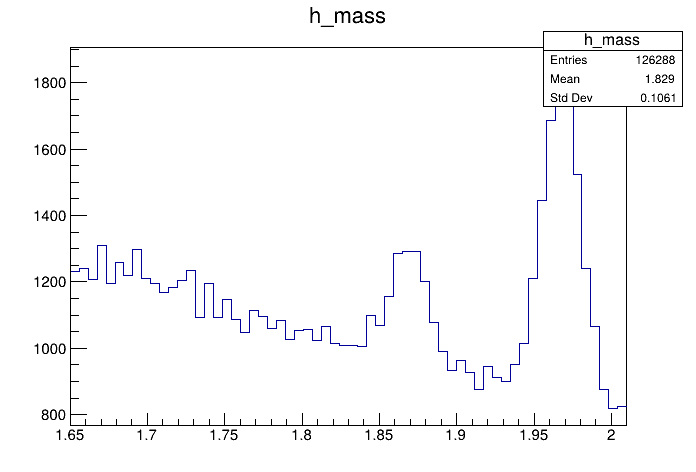

In [22]:
# Create a histogram from `x` and draw it
#with performance_report(filename="my_report.html"):
if 1:
  h = df.Histo1D(("h_mass", "h_mass", 62, 1.65, 2.01), "BestTriplet_mass")
  c =  ROOT.TCanvas()
  h.Draw("hist")
  c.Draw()
  # Save output for further processing: snapshot saves on workers!
  df_out = df.Snapshot("ntuple", "out.root", ["BestTriplet_mass"])

In [23]:
client.run(ls)

{'tcp://10.42.0.103:39267': ['Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json',
  'storage',
  'x509up_u0'],
 'tcp://10.42.2.120:34585': ['Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json',
  'storage',
  'x509up_u0'],
 'tcp://10.42.2.121:37701': ['Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json',
  'storage',
  'x509up_u0'],
 'tcp://10.42.3.152:41073': ['Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json',
  'storage',
  'x509up_u0'],
 'tcp://10.42.3.153:34233': ['Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json',
  'storage',
  'x509up_u0'],
 'tcp://10.42.5.126:42413': ['Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json',
  'storage',
  'x509up_u0'],
 'tcp://10.42.6.156:38785': ['Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json',
  'storage',
  'x509up_u0'],
 'tcp://10.42.6.157:39019': ['Efficiency_muon_trackerMuon_Run2017_UL_ID_schemaV2.json',
  'storage',
  'x509up_u0']}

[#1] INFO:Eval -- RooRealVar::setRange(BestTriplet_mass) new range named 'R1' created with bounds [1.93,2.01]
[#1] INFO:Eval -- RooRealVar::setRange(BestTriplet_mass) new range named 'R2' created with bounds [1.83,1.89]
[#1] INFO:Eval -- RooRealVar::setRange(BestTriplet_mass) new range named 'R3' created with bounds [1.65,1.84]
[#1] INFO:Eval -- RooRealVar::setRange(BestTriplet_mass) new range named 'R4' created with bounds [1.89,1.925]
[#1] INFO:Eval -- RooRealVar::setRange(BestTriplet_mass) new range named 'R5' created with bounds [1.99,2.02]
[#1] INFO:Eval -- RooRealVar::setRange(BestTriplet_mass) new range named 'R6' created with bounds [1.65,2.01]
[#1] INFO:Eval -- RooRealVar::setRange(BestTriplet_mass) new range named 'fit_nll_sig_right_data' created with bounds [1.93,2.01]
[#1] INFO:Fitting -- RooAbsPdf::fitTo(sig_right_over_sig_right_Int[BestTriplet_mass|R1]) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- using CPU computation

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -43455.60093 Edm =      -2917.552742 NCalls =     19
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : -43610.98221
  Edm           : 250.5591073
  Internal parameters:	[    0.05172729461    -0.6638599611    -0.6751315329     -1.188233129]	
  Internal gradient  :	[     -731.0277444     -4136.579366      -3435.25436      14.56549339]	
  Internal covariance matrix:
[[  7.4826953e-06              0              0              0]
 [              0  3.9507269e-05              0              0]
 [              0              0  2.7218168e-05              0]
 [              0              0              0   0.0047914329]]]
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : -43610.98221
  

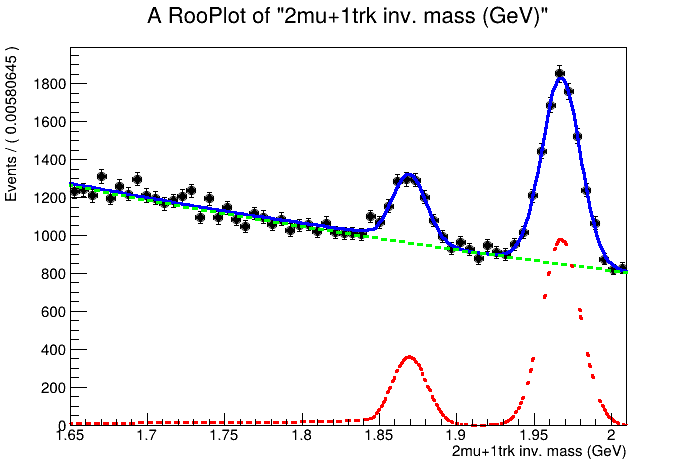

In [24]:
#fitting invariant mass :)
from ROOT import RooRealVar

x = ROOT.RooRealVar("BestTriplet_mass", "2mu+1trk inv. mass (GeV)", 1.65, 2.01)
x.setBins(62)

dh = ROOT.RooDataHist("data", "h_mass", ROOT.RooArgSet(x), Import=h.GetValue())
entries = h.GetValue().GetEntries()

#set ranges
x.setRange("R1",1.93,2.01) #main peak Ds(1.97)
x.setRange("R2",1.83,1.89) #second peak D+(1.87GeV)
x.setRange("R3",1.65,1.84) #background    
x.setRange("R4",1.89,1.925) #background    
x.setRange("R5",1.99,2.02) #background    
x.setRange("R6",1.65,2.01) #full range  

meanCB = RooRealVar("mean", "meanCB", 1.97, 1.94, 2.1)
sigmaCB1 = RooRealVar("#sigma_{CB}", "sigmaCB1", 0.02, 0.001, 0.1)
alpha1 = RooRealVar("#alpha1", "alpha1", 1.0, -10, 10)
nSigma1 = RooRealVar("n1", "n1", 1.0, 0.1, 25.0)
sig1 = ROOT.RooCBShape("sig_right", "sig_right", x, meanCB, sigmaCB1, alpha1, nSigma1)
sig1.fitTo(dh, ROOT.RooFit.Range("R1"))

meanCB2 = RooRealVar("mean2", "meanCB2", 1.87, 1.82, 1.89)
sigmaCB2 = RooRealVar("#sigma2_{CB}", "sigmaCB2", 0.05, 0.001, 0.05)
alpha2 = RooRealVar("#alpha2", "alpha2", 1.0, -10, 10)
nSigma2 = RooRealVar("n2", "n2", 1.0, 0.1, 25.0)
sig2 = ROOT.RooCBShape("sig_left", "sig_left", x, meanCB2, sigmaCB2, alpha2, nSigma2)
sig2.fitTo(dh, ROOT.RooFit.Range("R2"))

gamma = RooRealVar("#Gamma", "Gamma", -1, -2.0, -1e-2)
exp_bkg = ROOT.RooExponential("exp_bkg", "exp_bkg", x, gamma)
exp_bkg.fitTo(dh, ROOT.RooFit.Range("R3,R4,R5"))

nSig1 = RooRealVar("nSig1", "Number of signal candidates", entries*0.05, 1.0, entries)
nSig2 = RooRealVar("nSig2", "Number of signal 2 candidates", entries*0.02, 1.0, entries)
nBkg = RooRealVar("nBkg", "Bkg component", entries*0.8, 1.0, entries)

totalPDF = ROOT.RooAddPdf("totalPDF", "totalPDF", ROOT.RooArgList(sig1, sig2, exp_bkg), ROOT.RooArgList(nSig1, nSig2, nBkg))

r = totalPDF.fitTo(dh, ROOT.RooFit.Extended(ROOT.kTRUE), ROOT.RooFit.Save(ROOT.kTRUE))

c = ROOT.TCanvas()
xframe = x.frame()
#totalPDF.paramOn(xframe, ROOT.RooFit.Parameters(ROOT.RooArgSet(meanCB, meanCB2, sigmaCB1, sigmaCB2, gamma, nSig_right, nSig_left, nBkg)), ROOT.RooFit.Layout(0.2, 0.2, 0.6))
dh.plotOn(xframe)
totalPDF.plotOn(xframe)
totalPDF.plotOn(xframe, ROOT.RooFit.Components(exp_bkg), ROOT.RooFit.LineColor(ROOT.kGreen), ROOT.RooFit.LineStyle(ROOT.kDashed))
totalPDF.plotOn(xframe, ROOT.RooFit.Components(ROOT.RooArgSet(sig1, sig2)), ROOT.RooFit.LineColor(ROOT.kRed), ROOT.RooFit.LineStyle(ROOT.kDashed) )
xframe.Draw()
c.Draw()
c.SaveAs("mass.png")